In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import chi2_contingency, ttest_ind
from IPython.display import display

In [2]:
# Load data
df = pd.read_csv("post_pandemic_remote_work_health_impact_2025.csv")
df.head()

,Survey_Date,Age,Gender,Region,Industry,Job_Role,Work_Arrangement,Hours_Per_Week,Mental_Health_Status,Burnout_Level,Work_Life_Balance_Score,Physical_Health_Issues,Social_Isolation_Score,Salary_Range
0,2025-06-01,27,Female,Asia,Professional Services,Data Analyst,Onsite,64,Stress Disorder,High,3,Shoulder Pain; Neck Pain,2,$40K-60K
1,2025-06-01,37,Female,Asia,Professional Services,Data Analyst,Onsite,37,Stress Disorder,High,4,Back Pain,2,$80K-100K
2,2025-06-01,32,Female,Africa,Education,Business Analyst,Onsite,36,ADHD,High,3,Shoulder Pain; Eye Strain,2,$80K-100K
3,2025-06-01,40,Female,Europe,Education,Data Analyst,Onsite,63,ADHD,Medium,1,Shoulder Pain; Eye Strain,2,$60K-80K
4,2025-06-01,30,Male,South America,Manufacturing,DevOps Engineer,Hybrid,65,NaN,Medium,5,NaN,4,$60K-80K


In [3]:
# Filter to include only remote workers
df_remote = df[df["Work_Arrangement"] == "Remote"].copy()
df_remote.head()

,Survey_Date,Age,Gender,Region,Industry,Job_Role,Work_Arrangement,Hours_Per_Week,Mental_Health_Status,Burnout_Level,Work_Life_Balance_Score,Physical_Health_Issues,Social_Isolation_Score,Salary_Range
8,2025-06-01,30,Female,South America,Technology,Software Engineer,Remote,47,Anxiety,Medium,2,Neck Pain,4,$60K-80K
11,2025-06-01,64,Male,North America,Technology,Business Analyst,Remote,35,ADHD,Medium,3,Eye Strain; Wrist Pain,4,$40K-60K
13,2025-06-01,37,Male,Europe,Finance,UX Designer,Remote,59,Anxiety,High,5,Back Pain; Shoulder Pain; Wrist Pain,5,$60K-80K
14,2025-06-01,50,Male,Europe,Professional Services,Social Media Manager,Remote,64,Burnout,Medium,1,NaN,4,$60K-80K
19,2025-06-01,27,Female,Africa,Healthcare,Account Manager,Remote,43,NaN,Medium,1,NaN,4,$80K-100K


In [4]:
# Check for duplicates
print("Duplicates:", df_remote.duplicated().sum())

Duplicates: 0


In [5]:
# Quick look at nulls
print("Missing values per column:")
null_counts = df_remote.isnull().sum().reset_index()
null_counts.columns = ["Column", "Null Values"]
display(null_counts)

Missing values per column:


,Column,Null Values
0,Survey_Date,0
1,Age,0
2,Gender,0
3,Region,0
4,Industry,0
5,Job_Role,0
6,Work_Arrangement,0
7,Hours_Per_Week,0
8,Mental_Health_Status,163
9,Burnout_Level,0


In [6]:
# Take care of columns with missing values
df_remote["Mental_Health_Status"] = df_remote["Mental_Health_Status"].fillna("None")
df_remote["Physical_Health_Issues"] = df_remote["Physical_Health_Issues"].fillna("None")

null_counts = df_remote.isnull().sum().reset_index()
null_counts.columns = ["Column", "Null Values"]
display(null_counts)

,Column,Null Values
0,Survey_Date,0
1,Age,0
2,Gender,0
3,Region,0
4,Industry,0
5,Job_Role,0
6,Work_Arrangement,0
7,Hours_Per_Week,0
8,Mental_Health_Status,0
9,Burnout_Level,0


In [7]:
# Get all issues in Physical_Health_Issues, split by ;
issues = set(
    df_remote["Physical_Health_Issues"]
    .str.split(";")
    .apply(lambda x: [issue.strip() for issue in x if issue.strip()])
    .explode()
    .dropna()
    .unique()
)
issues.remove("None")
issues.add("No Physical Health Issues")

# One-hot encode selected health issues for remote workers, using True/False
df_remote["Physical_Health_Issues"] = (
    df_remote["Physical_Health_Issues"]
    .replace("None", "No Physical Health Issues")
    .astype(str)
)
for issue in issues:
    colname = issue.replace(" ", "_")
    df_remote[colname] = df_remote["Physical_Health_Issues"].apply(lambda x: issue in x)

In [8]:
# Categorical summaries (using display for better output)
categorical_cols = {
    "Gender",
    "Region",
    "Industry",
    "Job_Role",
    "Work_Arrangement",
    "Mental_Health_Status",
    "Burnout_Level",
    "Salary_Range",
}.union([issue.replace(" ", "_") for issue in issues])
numericals_cols = (
    set(df_remote.columns)
    .difference(categorical_cols)
    .difference({"Physical_Health_Issues", "Survey_Date"})
)

df_categorical = df_remote[list(categorical_cols)]
df_numerical = df_remote[list(numericals_cols)]

In [9]:
# Creating a dictionary to store the labeled dataframes
categorical_summary_dfs = {
    col: pd.concat(
        [
            df_categorical[col].value_counts(normalize=True),
            df_categorical[col].value_counts(),
        ],
        axis=1,
        keys=["proportion", "count"],
    )
    for col in df_categorical
}

# Concatenating along axis=0 with keys as column labels
categorical_summary_df = pd.concat(categorical_summary_dfs, axis=0)

# Displaying the dataframe
pd.set_option("display.max_rows", None)
display(categorical_summary_df)
pd.reset_option("display.max_rows")

proportion  count
Wrist_Pain                False                           0.833333    490
                          True                            0.166667     98
Mental_Health_Status      None                            0.277211    163
                          PTSD                            0.132653     78
                          Anxiety                         0.127551     75
                          ADHD                            0.120748     71
                          Stress Disorder                 0.120748     71
                          Depression                      0.113946     67
                          Burnout                         0.107143     63
Gender                    Male                            0.498299    293
                          Female                          0.465986    274
                          Non-binary                      0.023810     14
                          Prefer not to say               0.011905      7
Salary_Range              $60K-80K                        0.304422    179
                          $80K-100K                       0.294218    173
                          $40K-60K                        0.205782    121
                          $100K-120K                      0.129252     76
                          $120K+                          0.066327     39
Shoulder_Pain             False                           0.534014    314
                          True                            0.465986    274
Eye_Strain                True                            0.511905    301
                          False                           0.488095    287
Work_Arrangement          Remote                          1.000000    588
Industry                  Technology                      0.340136    200
                          Professional Services           0.161565     95
                          Manufacturing                   0.153061     90
                          Finance                         0.090136     53
                          Education                       0.078231     46
                          Healthcare                      0.052721     31
                          Customer Service                0.045918     27
                          Retail                          0.045918     27
                          Marketing                       0.032313     19
Job_Role                  Operations Manager              0.052721     31
                          Research Scientist              0.052721     31
                          Quality Assurance               0.052721     31
                          Data Analyst                    0.051020     30
                          Product Manager                 0.049320     29
                          IT Support                      0.047619     28
                          Data Scientist                  0.047619     28
                          Social Media Manager            0.044218     26
                          Project Manager                 0.044218     26
                          Customer Service Manager        0.044218     26
                          UX Designer                     0.042517     25
                          Software Engineer               0.040816     24
                          Technical Writer                0.040816     24
                          Digital Marketing Specialist    0.040816     24
                          Consultant                      0.039116     23
                          Content Writer                  0.039116     23
                          Business Analyst                0.039116     23
                          HR Manager                      0.039116     23
                          Sales Representative            0.037415     22
                          Executive Assistant             0.035714     21
                          Financial Analyst               0.034014     20
                          DevOps Engineer                 0.

In [10]:
# Outlier checks
df_outliers = pd.DataFrame(
    {
        "Age < 18": df_numerical["Age"] < 18,
        "Age > 65": df_numerical["Age"] > 65,
        "Hours_Per_Week < 0": df_numerical["Hours_Per_Week"] < 0,
        "Hours_Per_Week > 80": df_numerical["Hours_Per_Week"] > 80,
    }
)
df_outliers = df_outliers.sum().reset_index()
df_outliers.columns = ["Condition", "Count"]
display(df_outliers)

,Condition,Count
0,Age < 18,0
1,Age > 65,0
2,Hours_Per_Week < 0,0
3,Hours_Per_Week > 80,0


## Exploratory Data Analysis (EDA) on Burnout in Remote Work

In [11]:
# Summary statistics for all numeric columns
display(df_numerical.describe())

# describe numerical columns based on Burnout level
for col in numericals_cols:
    print(f"Summary statistics for {col} by Burnout Level:")
    display(df_numerical.groupby(df_remote["Burnout_Level"])[col].describe())

,Age,Social_Isolation_Score,Work_Life_Balance_Score,Hours_Per_Week
count,588.000000,588.000000,588.000000,588.000000
mean,44.284014,3.496599,2.993197,49.872449
std,12.485738,1.147543,1.207566,8.875001
min,22.000000,1.000000,1.000000,35.000000
25%,34.000000,3.000000,2.000000,42.750000
50%,45.000000,4.000000,3.000000,50.000000
75%,55.000000,4.000000,4.000000,57.000000
max,65.000000,5.000000,5.000000,65.000000


Summary statistics for Age by Burnout Level:


,count,mean,std,min,25%,50%,75%,max
Burnout_Level,,,,,,,,
High,273.0,44.498168,12.495330,22.0,34.0,45.0,56.0,65.0
Low,81.0,44.296296,12.578200,23.0,35.0,45.0,54.0,65.0
Medium,234.0,44.029915,12.491506,22.0,33.0,45.0,54.0,65.0


Summary statistics for Social_Isolation_Score by Burnout Level:


,count,mean,std,min,25%,50%,75%,max
Burnout_Level,,,,,,,,
High,273.0,3.446886,1.174922,1.0,3.0,4.0,4.0,5.0
Low,81.0,3.530864,1.119000,1.0,3.0,4.0,4.0,5.0
Medium,234.0,3.542735,1.127252,1.0,3.0,4.0,4.0,5.0


Summary statistics for Work_Life_Balance_Score by Burnout Level:


,count,mean,std,min,25%,50%,75%,max
Burnout_Level,,,,,,,,
High,273.0,3.036630,1.224195,1.0,2.0,3.0,4.0,5.0
Low,81.0,3.000000,1.214496,1.0,2.0,3.0,4.0,5.0
Medium,234.0,2.940171,1.188577,1.0,2.0,3.0,4.0,5.0


Summary statistics for Hours_Per_Week by Burnout Level:


,count,mean,std,min,25%,50%,75%,max
Burnout_Level,,,,,,,,
High,273.0,49.769231,9.085068,35.0,42.0,50.0,57.0,65.0
Low,81.0,48.950617,8.549709,35.0,42.0,49.0,56.0,65.0
Medium,234.0,50.311966,8.745379,35.0,43.0,50.0,58.0,65.0


## Visualizations

In [12]:
def plot_boxplots(col):
    plt.figure(figsize=(12, 3))

    # plot distributions of each column for each burnout level for all numerical columns
    plt.subplot(1, 3, 1)
    # plot distributions of each column for each burnout level
    sns.histplot(
        df_numerical[col].loc[df_remote["Burnout_Level"] == "Low"],
        kde=True,
        discrete=True,
    )
    plt.title(f"{col} distribution\n(Low Burnout)")
    plt.subplot(1, 3, 2)
    sns.histplot(
        df_numerical[col].loc[df_remote["Burnout_Level"] == "Medium"],
        kde=True,
        discrete=True,
    )
    plt.title(f"{col} distribution\n(Medium Burnout)")
    plt.subplot(1, 3, 3)
    sns.histplot(
        df_numerical[col].loc[df_remote["Burnout_Level"] == "High"],
        kde=True,
        discrete=True,
    )
    plt.title(f"{col} distribution\n(High Burnout)")
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.25)
    plt.show()

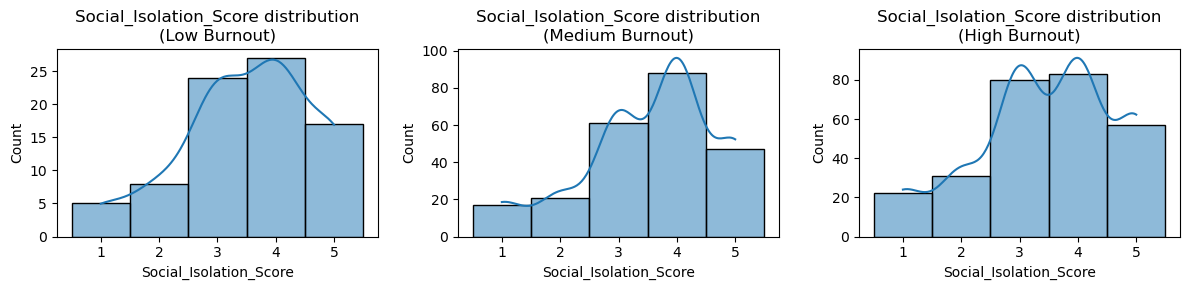

In [13]:
plot_boxplots('Social_Isolation_Score')

`Social_Isolation_Score` shows densities skewing more right as burnout level increases, indicating that higher social isolation is associated with higher burnout levels.

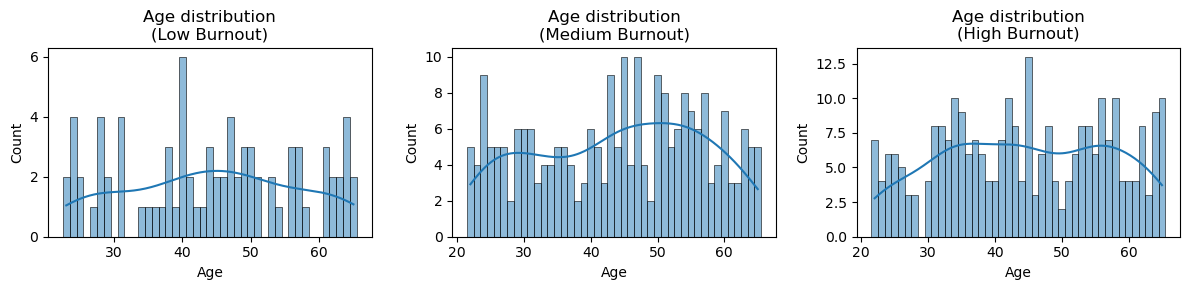

In [14]:
plot_boxplots('Age')

The `Age` distribution remote workers experiencing Low burnout is normal, while medium and high burnout show a right skew, indicating that younger workers are less likely to experience burnout.

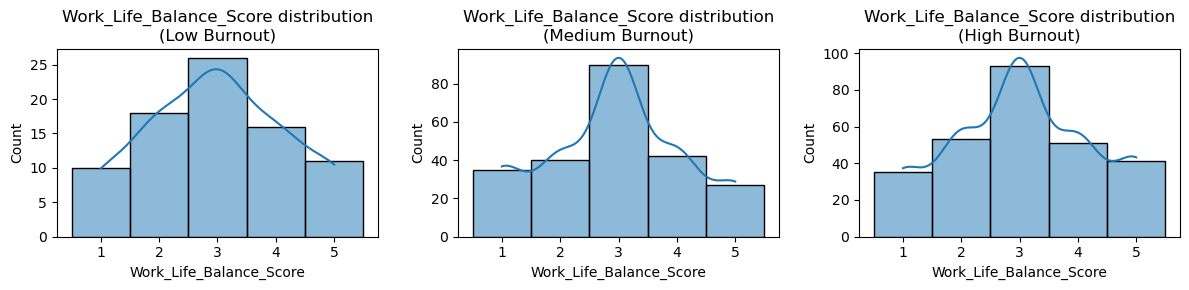

In [15]:
plot_boxplots('Work_Life_Balance_Score')

The `Work_Life_Balance_Score` distribution for medium and high burnout levels are more concentrated around the middle of the scale, indicating that individuals with medium and high burnout have less favorable work-life balance compared to those with low burnout.

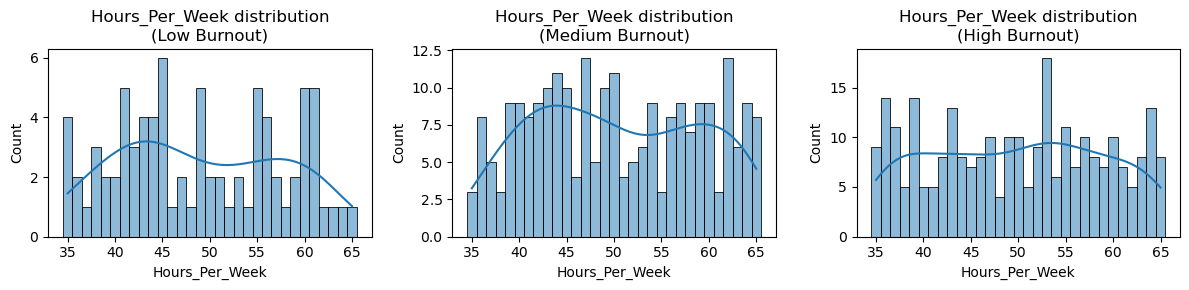

In [16]:
plot_boxplots('Hours_Per_Week')

The `Hours_Per_Week` distribution shifts from a left-skewed distribution to a more uniform distribution as burnout levels increase, indicating that individuals with higher burnout levels tend to work more hours per week.

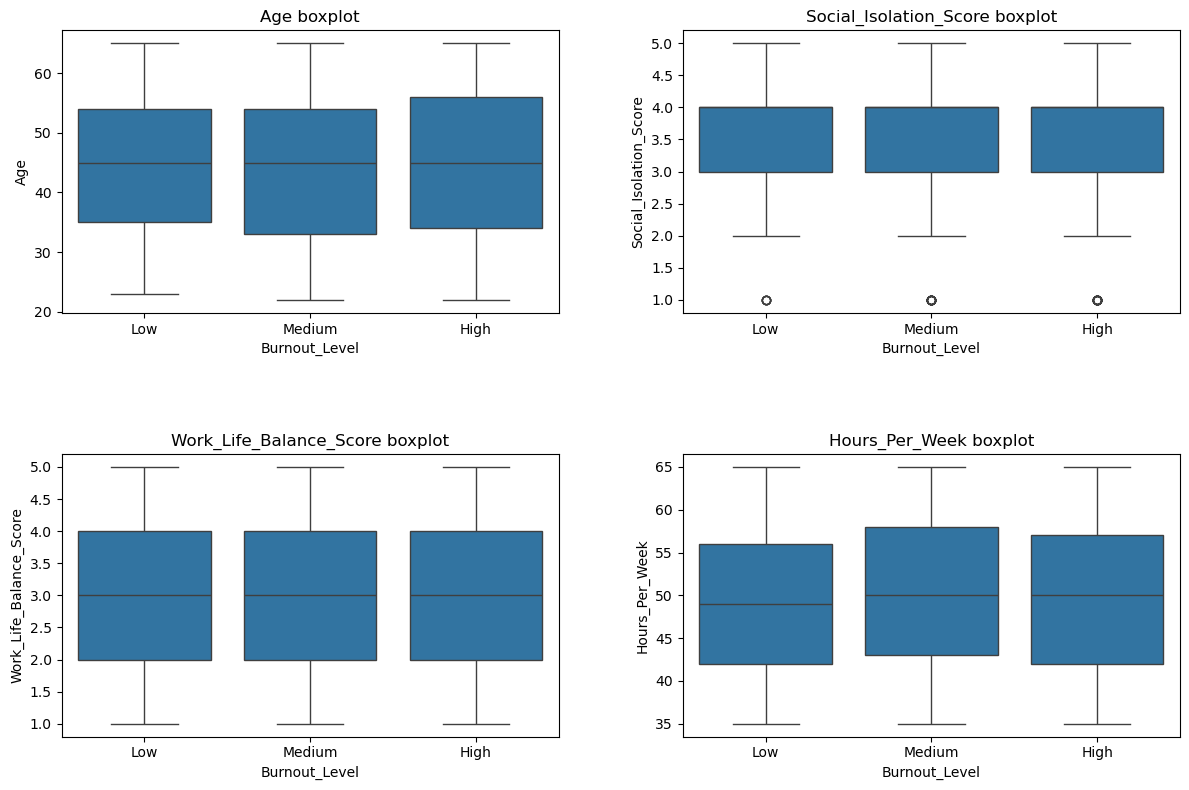

In [17]:
plt.figure(figsize=(12, 8))
for i, col in enumerate(df_numerical.columns, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(
        x=df_categorical["Burnout_Level"],
        y=df_numerical[col],
        order=["Low", "Medium", "High"],
    )
    plt.title(f"{col} boxplot")
plt.tight_layout()
plt.subplots_adjust(hspace=0.5, wspace=0.25)
plt.show()

The boxplot visualizations show that `Social_Isolation_Score` and `Work_Life_Balance_Score` have similar shapes across the different burnout categories.  

`Hours_Per_Week` shows a slight increase in the median and interquartile range as burnout levels increase. This suggests that individuals who work more hours are more likely to experience higher levels of burnout.  

`Age` shows the same median across all burnout levels, but the interquartile range widens as burnout levels increase, indicating more variability in age among those with higher burnout levels.

In [18]:
def plot_violin(col):
    sns.violinplot(
        x="Burnout_Level",
        y=col,
        data=pd.concat([df_categorical["Burnout_Level"], df_numerical], axis=1),
        inner="box",
        cut=0,
        order=["Low", "Medium", "High"],
        palette="Blues",
        hue="Burnout_Level",
        hue_order=["Low", "Medium", "High"],
    )
    plt.title(f"{col} by burnout level")
    plt.subplots_adjust(hspace=0.5, wspace=0.25)
    plt.show()

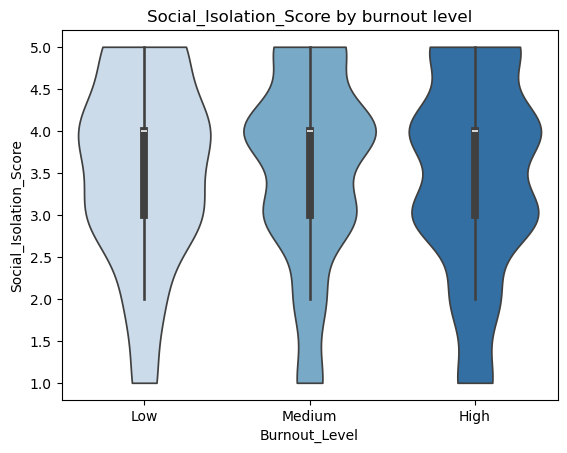

In [19]:
plot_violin('Social_Isolation_Score')

As `Burnout_Level` increases, the distribution of `Social_Isolation_Score` becomes more right skewed, indicating that individuals with higher burnout levels tend to experience higher social isolation.

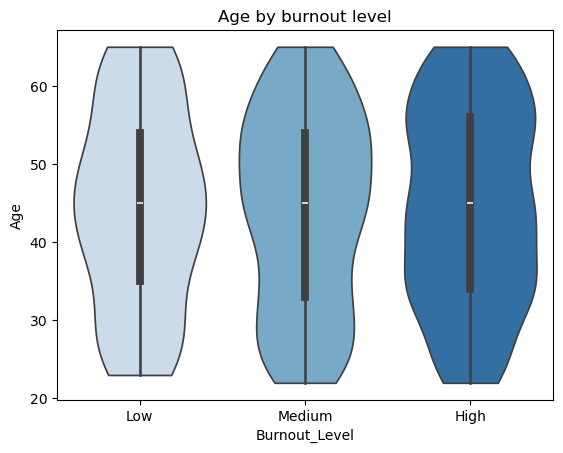

In [20]:
plot_violin('Age')

As `Burnout_Level` increases, the density of `Age` becomes more uniform, indicating that individuals with higher burnout levels are more evenly distributed across different age groups.

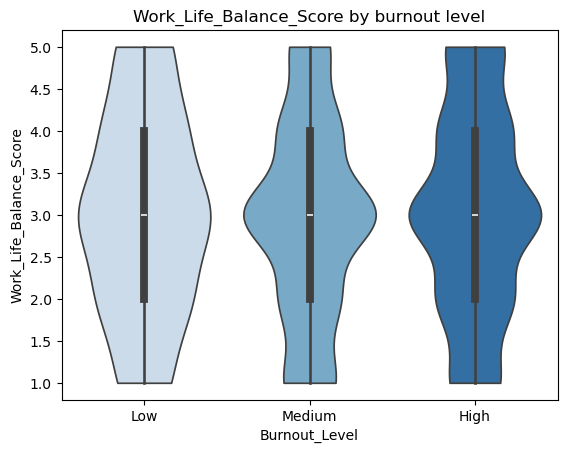

In [21]:
plot_violin('Work_Life_Balance_Score')

As `Burnout_Level` increases, the `Work_Life_Balance_Score` becomes more concentrated around the middle of the scale, indicating that individuals with higher burnout levels have less favorable work-life balance. Interestingly, there is a higher density of individuals with Low burnout who also have low `Work_Life_Balance_Score`, suggesting that some individuals with low burnout may still struggle with work-life balance.

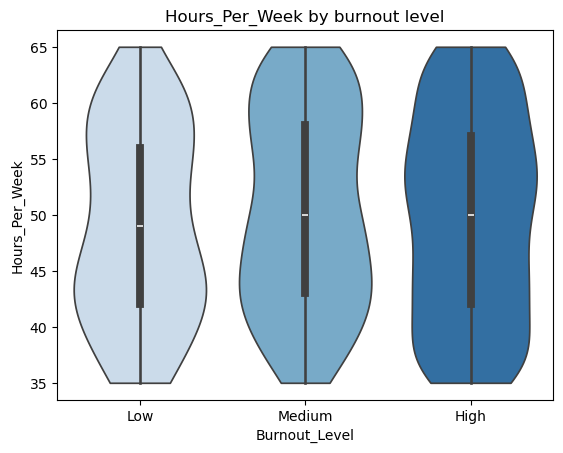

In [22]:
plot_violin('Hours_Per_Week')

As `Burnout_Level` increases, the density of `Hours_Per_Week` shifts from left skewed to right skewed and the median increases, indicating that individuals with higher burnout levels tend to work more hours per week.

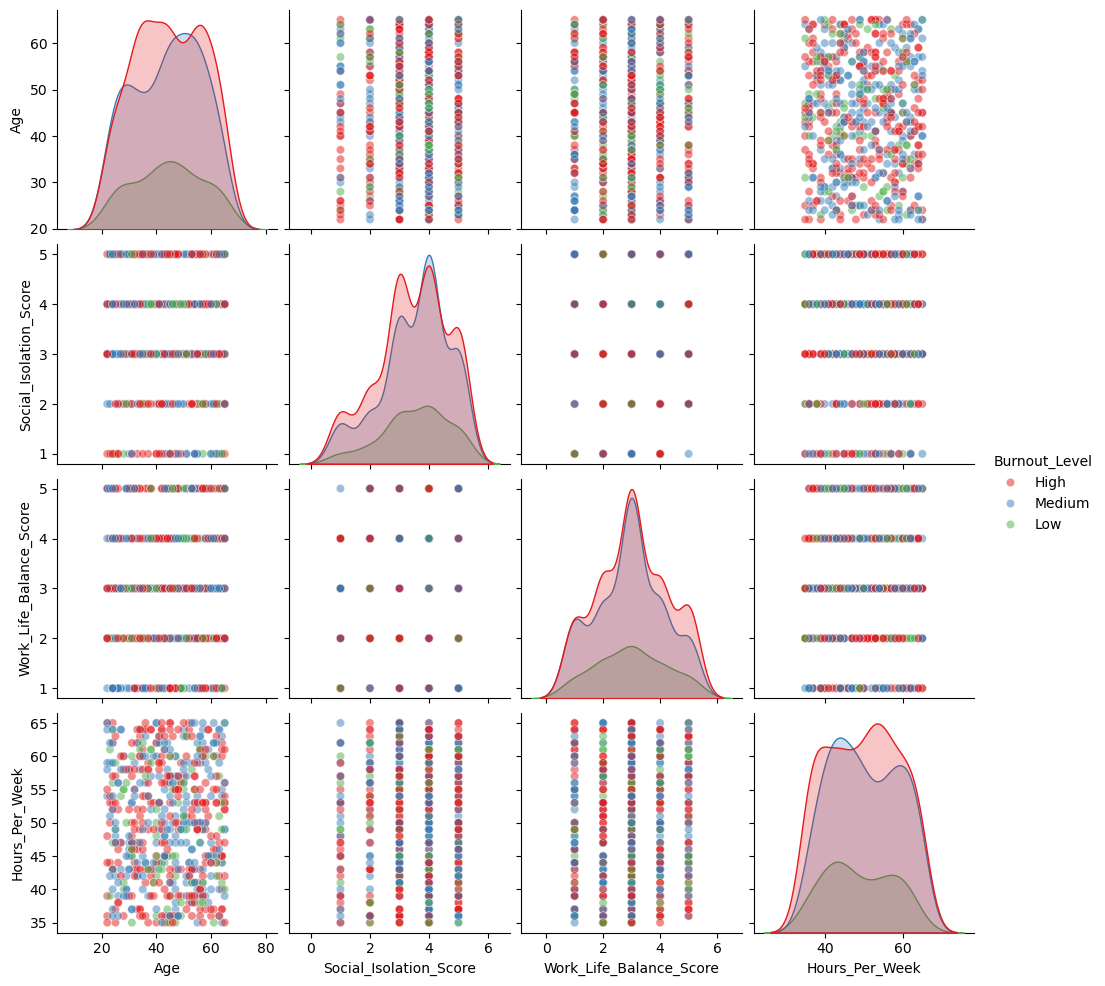

In [23]:
sns.pairplot(
    df_remote,
    vars=df_numerical.columns,
    diag_kind="kde",
    plot_kws={"alpha": 0.5},
    height=2.5,
    palette="Set1",
    hue="Burnout_Level",
    hue_order=["High", "Medium", "Low"],
)
plt.show()

- `Social_Isolation_Score` is positively correlated with burnout levels, with higher scores indicating larger densities in the medium and high burnout categories.
- `Work_Life_Balance_Score` shows a negative correlation with burnout levels, where lower scores are associated with larger densities in the medium and high burnout categories.

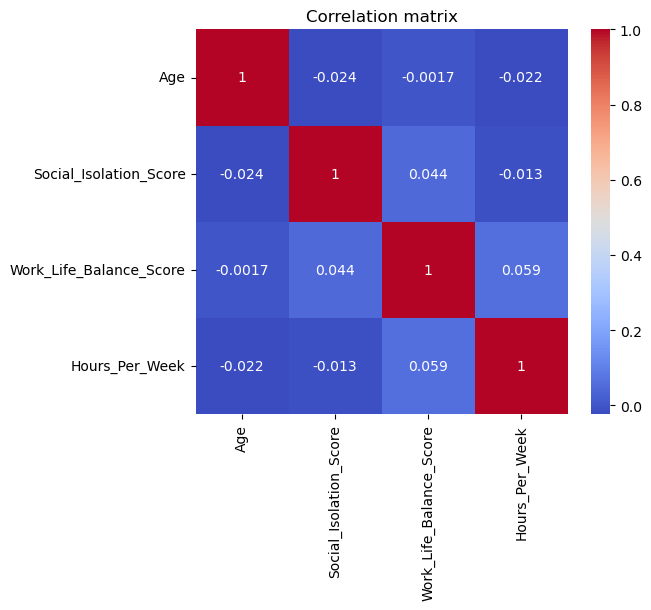

In [24]:
plt.figure(figsize=(6, 5))
corr = df_numerical.corr()
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Correlation matrix")
plt.show()

None of the numerical features show correlation with each other, indicating that they are all independent of each other.

## Significance Testing

In [25]:
print("T-test for Low vs Medium and High Burnout Levels")
ttest_ind_results = []
for col in numericals_cols:
    group1 = df_remote[df_remote["Burnout_Level"] != "Low"][col]
    group0 = df_remote[df_remote["Burnout_Level"] == "Low"][col]
    t_stat, p_val = ttest_ind(group1, group0, equal_var=False)
    ttest_ind_results.append(
        {
            "Column": col,
            "T-statistic": t_stat,
            "P-value": p_val,
            "Conclusion": (
                "Significant difference"
                if p_val < 0.05
                else "No significant difference"
            ),
        }
    )
ttest_ind_results_df = pd.DataFrame(ttest_ind_results)
display(ttest_ind_results_df)

T-test for Low vs Medium and High Burnout Levels


,Column,T-statistic,P-value,Conclusion
0,Age,-0.009474,0.992458,No significant difference
1,Social_Isolation_Score,-0.295540,0.768144,No significant difference
2,Work_Life_Balance_Score,-0.054331,0.956773,No significant difference
3,Hours_Per_Week,1.038625,0.301262,No significant difference


The t-tests results indicate that there are no significant differences between the `High+Medium` and `Low` burnout groups for the quantitative features. This suggests that the differences in the distributions of these features across burnout levels are not statistically significant.

In [26]:
print("T-test for Low vs High Burnout Levels")
ttest_ind_results = []
for col in numericals_cols:
    group1 = df_remote[df_remote["Burnout_Level"] == "High"][col]
    group0 = df_remote[df_remote["Burnout_Level"] == "Low"][col]
    t_stat, p_val = ttest_ind(group1, group0, equal_var=False)
    ttest_ind_results.append(
        {
            "Column": col,
            "T-statistic": t_stat,
            "P-value": p_val,
            "Conclusion": (
                "Significant difference"
                if p_val < 0.05
                else "No significant difference"
            ),
        }
    )
ttest_ind_results_df = pd.DataFrame(ttest_ind_results)
display(ttest_ind_results_df)

T-test for Low vs High Burnout Levels


,Column,T-statistic,P-value,Conclusion
0,Age,0.127038,0.899106,No significant difference
1,Social_Isolation_Score,-0.586307,0.558637,No significant difference
2,Work_Life_Balance_Score,0.237940,0.812296,No significant difference
3,Hours_Per_Week,0.745805,0.457053,No significant difference


The t-tests results indicate that there are no significant differences between the `High` and `Low` burnout groups for the quantitative features. This suggests that the differences in the distributions of these features across burnout levels are not statistically significant.

In [27]:
chi2_results = []
for col in categorical_cols:
    if col == "Burnout_Level":
        continue
    contingency_table = pd.crosstab(df_remote[col], df_remote["Burnout_Level"])
    chi2_stat, p_val_chi2, dof, expected = chi2_contingency(contingency_table)
    chi2_results.append(
        {
            "Column": col,
            "Chi-squared Statistic": chi2_stat,
            "P-value": p_val_chi2,
            "Conclusion": (
                "Association exists" if p_val_chi2 < 0.05 else "No association"
            ),
        }
    )
chi2_results_df = pd.DataFrame(chi2_results)
display(chi2_results_df)

,Column,Chi-squared Statistic,P-value,Conclusion
0,Wrist_Pain,10.028816,0.006642,Association exists
1,Mental_Health_Status,15.017915,0.240458,No association
2,Gender,2.910426,0.820002,No association
3,Salary_Range,4.090046,0.848909,No association
4,Shoulder_Pain,0.618908,0.733848,No association
5,Eye_Strain,1.726253,0.421841,No association
6,Work_Arrangement,0.000000,1.000000,No association
7,Industry,22.703213,0.121902,No association
8,Job_Role,40.048894,0.718729,No association
9,Neck_Pain,0.582931,0.747168,No association


The chi-squared test results indicate that only `Wrist_Pain` has an association with burnout levels, suggesting that individuals with wrist pain are more likely to experience higher levels of burnout.  

The other categorical features do not show significant associations with burnout levels, indicating that they may not be strong predictors of burnout.